# Author Citations vs Author PageRank 

Let us continue examining the metadata from InspireHEP to quantify the impact of papers and of authors using PageRank.

Let us see if we can takle the following question:
$$~$$
**Is citation-count correlated with an author's PageRank-based as a measure of impact?**
$$~$$

Let us focus on entries published in the last 20 years only. 

Ok, now let's get started

# Papers PageRank

In [30]:
import json
import networkx as nx
import numpy as np
from sklearn import linear_model
%matplotlib inline
import matplotlib
matplotlib.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'
from collections import Counter, defaultdict
from __future__ import division
import datetime
import math
from my_utils import *

We have collected the metadata from InspireHEP.
You can download a zipped file from https://inspirehep.net/info/hep/api. It's in JSON format, which is pretty readable in python. The typical paper entry is a python dict, with the following keys:

[u'free_keywords',
 u'title',
 u'abstract',
 u'co-authors',
 u'creation_date',
 u'standardized_keywords',
 u'citations',
 u'recid',
 u'authors',
 u'references']
 
 We'll build directed edges in a network, whose nodes are papers.
 That is, edges of the form (paper that cites, paper that's cited) 


Let's perform a bit of cleaning.
We want:

1. Get rid of proceedings or theses, and of any papers that have been withdrawn or canceled.
2. Get rid of papers that have 0 references. Why? Because no reputable paper would have zero references in it.
3. Similarly, let's get rid of papers that have 0 citations. There are more than 1 million nodes in the network, so at most these papers would endow PageRanks at the level of 10$^{-6}/N_{\rm{ref}}$ level, where $N_{\rm{ref}}$ is the number of references of that paper. More importantly, by making this restriction, we are choosing to include papers that already have earned *some* PageRank, to make the computation faster.
4. Also get rid of papers that for some reason don't list any authors.
2. Finally, we want to select only papers within a certain date period, if the dataset is still too large.

Let's read the data, clean it, and build the network

In [2]:
# let's read the data, clean it a bit, and build network

DG = nx.DiGraph() # directed graph. Edges are (paper that cites, paper that's cited)

authors_by_recid = defaultdict(list) # key is recid, value is author list of recid

citations_by_recid = defaultdict(int) # key is recid, value is citation count

json_path = '/Users/ederizaguirre/Research/FunProjects/InspireHEPNetworks/'

date_range = ('01-01-1997','06-30-2017') # select only papers within this range

with open(json_path + 'hep_records.json') as f:
    list(map(lambda x: compute_graph(DG, 
                                     authors_by_recid, 
                                     citations_by_recid,
                                     x,
                                     date_range
                                    ),
             f.readlines()
            )
        )

In [3]:
len(authors_by_recid)

450135

In [4]:
pr_by_recid = nx.pagerank(DG) # calculate the pagerank. alpha = 0.85

In [5]:
# let's sort the entries
pr_by_recid_sorted = sorted(pr_by_recid.items(), 
                            key=lambda x: x[1], 
                            reverse=True
                           )

In [6]:
# write to file to save time in future
with open('../data/recid_pr_last20years.dat','w') as f:
    for recid_i, pr_i in pr_by_recid_sorted:
        f.write(str(recid_i) + '\t' + str(pr_i) + '\n')

In [4]:
# In the future we can build the network from an input file
pr_by_recid_sorted = []
pr_by_recid = defaultdict(float)
with open('../data/recid_pr_last20years.dat') as f:
    for line in f:
        line = line.split()
        recid_i = int(line[0])
        pr_i = float(line[1])
        pr_by_recid_sorted.append((recid_i, pr_i))
        pr_by_recid[recid_i] = pr_i

In [7]:
len(pr_by_recid_sorted) # number of papers that have been cited

771159

In [8]:
pr_by_recid_sorted[:10] # the 10 papers with the highest pagerank

[(796888, 0.0008881054067422497),
 (593382, 0.0007689322414501506),
 (796887, 0.0005575790219939373),
 (451647, 0.0004574182762582009),
 (712925, 0.0004085650074182374),
 (484837, 0.0003920922005921952),
 (470671, 0.00036953235675226315),
 (1126428, 0.0003480577729342499),
 (462477, 0.0003335750148784821),
 (792295, 0.0003185138856169227)]

Which papers are these?

Here's the InspireHEP entry for the paper with the highest pagerank in the last 20 years:

![ATLAS](figs/ATLAS.png)
$$~$$
$$~$$

The standard citation paper for the ATLAS experiment.


And the paper with the second-most pagerank is:

![GEANT4](figs/GEANT4.png)
$$~$$
$$~$$

The standard citation for GEANT4. It's a universally used simulation program.

Ok, one more. How about the bronze medal? This goes to

![CMS](figs/CMS.png)
$$~$$
$$~$$
The standard citation for the CMS experiment, the other general purpose LHC experiment.


# Authors PageRank-based Impact

Let's try to quantify the rankings of authors. We will use the approach where pagerank is a conserved quantity, so we endow each of the authors of a paper with $pr/N$ where $pr$ is that paper's pagerank, and $N$ is the number of authors.

In [11]:
# let's build the cumulative authors' PageRank-based measure

# key is author; value is PR/len(authors)
pr_by_author = measure_by_author_dict(authors_by_recid, 
                                                  pr_by_recid, 
                                                  norm = 'len(authors)'
                                                 )

pr_by_author_sorted = sorted(pr_by_author.items(), 
                                         key = lambda x: x[1],
                                         reverse = True
                                        )

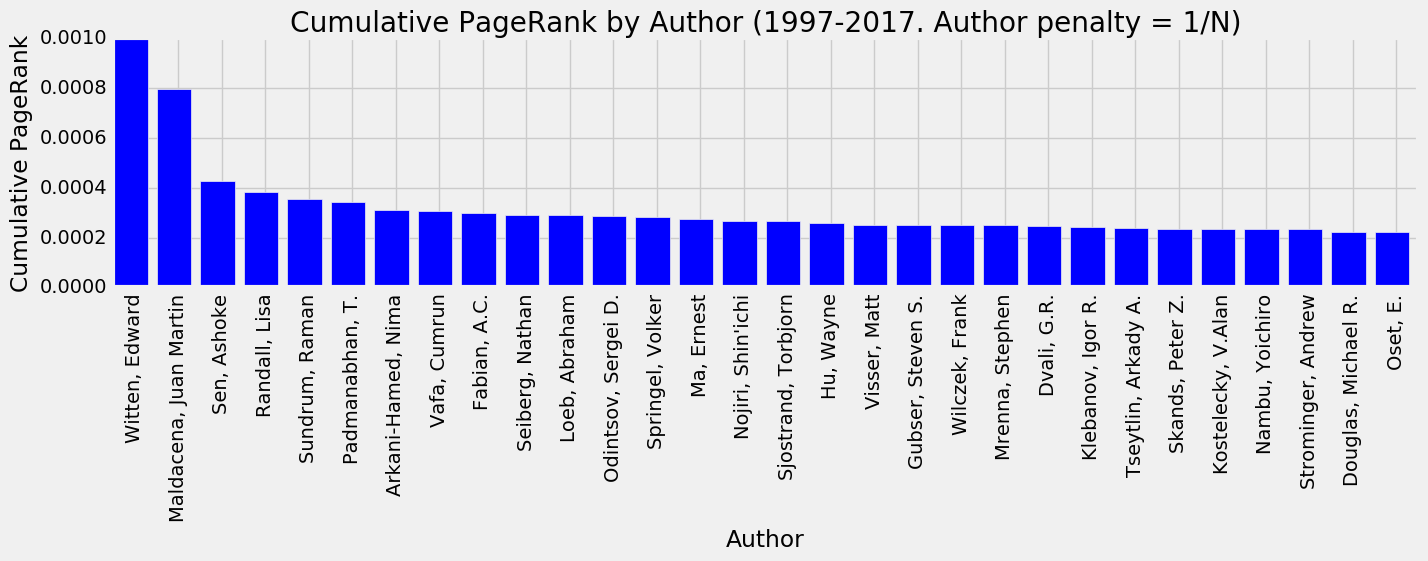

In [40]:
# and let's make a histogram
num_entries = 30
make_hist_by_author(pr_by_author_sorted,
                         'PageRank',
                         '1997-2017. Author penalty = 1/N',
                         num_entries)
plt.show()


Interesting list.
Witten still makes the top of course. A lot of new younger names, as we might expect.

# Are PageRank and Total Citation Count related?

Ok, is there a linear relationship between an author's total number of citations and their 
cumulative PR? Let's find out.

In [16]:
# we need to build the num_cites_by_author dict and sorted list

# key is author; value is num_cites
num_cites_by_author = measure_by_author_dict(authors_by_recid,
                                            citations_by_recid)

num_cites_by_author_sorted = sorted(num_cites_by_author.items(), 
                                    key = lambda x: x[1], 
                                    reverse = True
                                   )

In [17]:
# let's build arrays now for pr and for num_cites
num_cites = []
prs = []
for au, pr_i in pr_by_author_sorted:
    num_cites.append(num_cites_by_author[au])
    prs.append(pr_i)

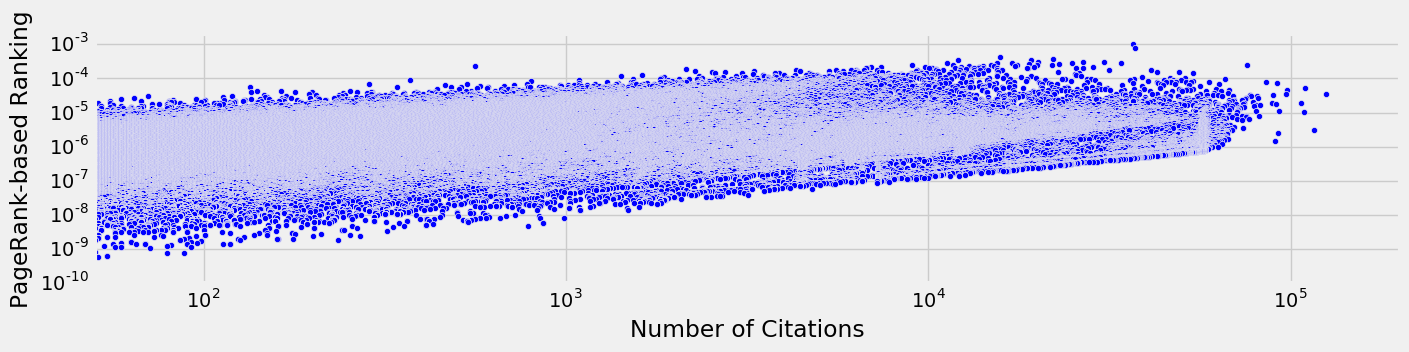

In [48]:
# Let's plot the data
plt.scatter(num_cites,prs)
plt.axis([50,200000,1e-10,0.002])
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Number of Citations")
plt.ylabel("PageRank-based Ranking")
plt.show()

While there is definitely a correlation, there is a huuuge spread!
Let's fit the data to a straight line to better quantify this.
Note, when doing linear regression, one usually wants to split the dataset into a training sample to build and fit a model's parameters, and a test sample where we can try to predict the values with the model we built. 

But here, we already know from the above figure that a linear fit won't be effective at predicting the PR of a paper or author as a function of citations. 

So, let me just use linear regression to **find** a straight line. And I'll treat the **entire** dataset as my training sample because I'm not trying to predict some further datapoints. All I want to do for now is to find outliers w/r to some expectation under the hypothesis of there being a linear relationship between total citation count and PR.

In [22]:
# convert arrays to numpy arrays, and reshape the independent variable
num_cites_np = np.array(num_cites).reshape(-1,1)
prs_np = np.array(prs)

In [23]:
# let's use linear regression to find a best-fit line.
# Again, we're not trying to predict values, so we'll just treat the entire sample
# as our training samle
x = num_cites_np
y = prs_np

In [24]:
regr=linear_model.LinearRegression() # use linear regression

In [25]:
regr.fit(x,y) # to fit a straight line

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# we find the fit coefficients from Pr = beta_0 + beta_1 * num_cites
print regr.intercept_,regr.coef_ # coefficient beta_0 and beta_1

1.89820075818e-06 [  1.09251598e-10]


In [27]:
y_predict = regr.predict(x) # y = Pr(predicted) if there were a linear relationship

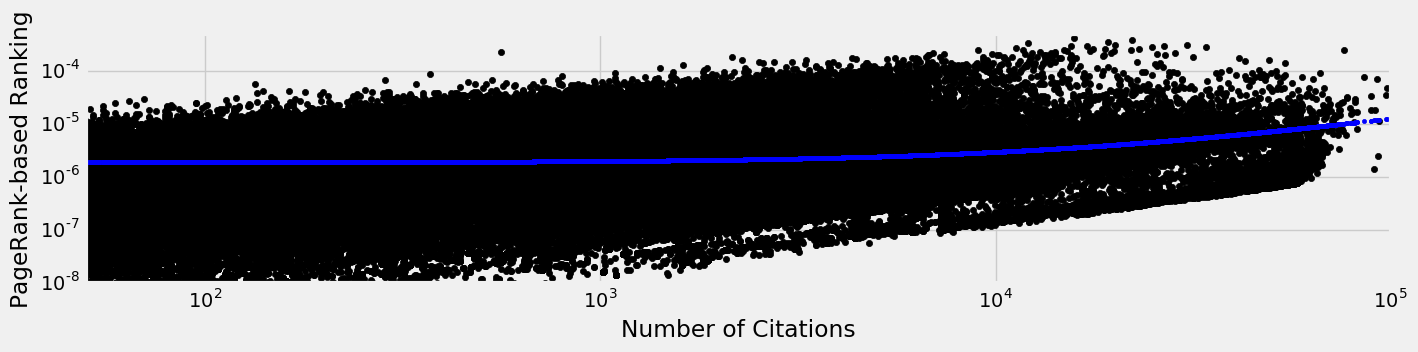

In [28]:
# let's see the data against a best-fit line

plt.scatter(x, y,  color='black')
plt.plot(x, y_predict,'.',color='blue')
plt.axis([50,100000,1e-8,0.0005])
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Number of Citations")
plt.ylabel("PageRank-based Ranking")
plt.show()

So, what would be really interesting is if we could find features or indicators that allow us to predict a high PR paper or author. But for now, we'll just examine some of the biggest outliers.

For this, we need the error bars on the estimated PR(num_citations) first. For now, since we are not trying to make predictions about our model on some test region, we will include the whole dataset (even the training region). So we are calculating the outliers w/r to the best-fit line

In [31]:
# compute the standard deviation of the dependent variable PR(num_citations)
sigma = (prs_np - regr.predict(num_cites_np))**2 

# two degrees of freedom beta_0 and beta_1 need to be subtracted from n_dof
std_dev = math.sqrt(sigma.sum()/(prs_np.shape[0]-2))
print std_dev # standard deviation

7.71600106447e-06


In [32]:
# compute the residuals
residuals = prs_np - y_predict

In [33]:
# get indices of outliers, in decreasing orders
res_index_sorted = residuals.argsort()[::-1]

In [47]:
# the biggest 10 outliers
print 'Name' + '\t\t'+'Citations'+ '\t'+'PageRank'+ '\t'+'Residual'
for i in res_index_sorted[:10]:
    print pr_by_author_sorted[i][0],num_cites[i],prs[i],residuals[i]

Name		Citations	PageRank	Residual
Witten, Edward 36778 0.00099623948161 0.000990323225584
Maldacena, Juan Martin 37178 0.000798217694349 0.000792257737684
Sen, Ashoke 15738 0.000425854517505 0.000422236915099
Randall, Lisa 22056 0.000381936363894 0.000377628509892
Sundrum, Raman 19235 0.00035345957393 0.000349459918686
Padmanabhan, T. 12064 0.000341716134952 0.000338499922917
Arkani-Hamed, Nima 30473 0.000312537953963 0.000307310529262
Vafa, Cumrun 20070 0.000306371673345 0.000302280793017
Fabian, A.C. 26709 0.000298002689512 0.000293186487826
Seiberg, Nathan 16962 0.000292590485703 0.000288839159341


Ok, so the top 10 outliers w/r to the hypothesis that "PR is linearly proportional to citations" are the top 10 PR-based authors.